This is an adaptation of.. [Few shot training](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb)  

This has been recently released and shows good promise...  
There are weights and configs available for efficientDet...    
The set up for efficientDet is also along the same lines...   
Just be sure to point to the right config file...  


TODO:   
* Add WBF to the predicitons
* loop around the gradient tape steps bettter.. to manage oom issue.. OR...
* Use the gradient tape along with tf dataset

In [1]:
!pip install -U --pre tensorflow=="2.2.0" # totally unncessary.. but hey no harm in double checking...

Requirement already up-to-date: tensorflow==2.2.0 in /opt/conda/lib/python3.7/site-packages (2.2.0)


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2797, done.
remote: Counting objects: 100% (2797/2797), done.
remote: Compressing objects: 100% (2439/2439), done.
remote: Total 2797 (delta 563), reused 1405 (delta 322), pack-reused 0
Receiving objects: 100% (2797/2797), 57.73 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (563/563), done.


In [3]:
cd models/research

/kaggle/working/models/research


In [4]:
# give it all absolute paths if this doesnt work...
# for any reason
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

object_detection/protos/input_reader.proto:5:1: warning: Import object_detection/protos/image_resizer.proto is unused.
Processing /kaggle/working/models/research
     |████████████████████████████████| 352 kB 2.9 MB/s 
     |████████████████████████████████| 711 kB 9.4 MB/s 
     |████████████████████████████████| 36.4 MB 32 kB/s 
     |████████████████████████████████| 165 kB 39.4 MB/s 
     |████████████████████████████████| 44 kB 1.5 MB/s 
     |████████████████████████████████| 294 kB 38.6 MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1532341 sha256=e2de52dbd577dceb7d999cfee94493d0c51e9643ead80fa801b97645fa04bb5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bkouegho/wheels/d3/e0/37/addaa349be05bc9a8e02e02876c3154afc70272d2a09a30920
  Created wheel for pycocotools: filename=pycocotools-2.0.1-cp37-cp37m-linux_x86_64.whl size=274053 sha256=e3a96b17e94c5963e18b45dd365e65b9659343dd145f6544a466f555d61623d2
  Stored in directory: /roo

In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import pandas as pd

from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
# from object_detection.utils import colab_utils
# this was for the annotator can be done away with in this kaggle env
from object_detection.builders import model_builder

%matplotlib inline

In [6]:
def load_image_into_numpy_array(path):
    ''
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.2)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [7]:
train_df = pd.read_csv('/kaggle/input/global-wheat-detection/train.csv')

In [8]:
train_df['bboxs'] = train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))

In [9]:
train_df.head()

,image_id,width,height,bbox,source,bboxs
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,"[26.0, 144.0, 124.0, 117.0]"


In [10]:
train_df.width.nunique(),train_df.height.nunique()

(1, 1)

In [11]:
def xyxy_to_yxyx(a): 
    #     a_row is  ndarray..
    a[2] = a[0]+a[2]
    a[3] = a[1]+a[3]
    a[0],a[1],a[2],a[3] = a[1],a[0],a[3],a[2] # xyxy to yxyx here..
    a = a/1024
           
    return a.reshape(1,4)

In [12]:
train_df['bbox_adj'] = '' 

In [13]:
train_df['bbox_adj'] = train_df['bboxs'].map(xyxy_to_yxyx)

In [14]:
image_name_and_bboxes = {} # placeholder dict for the images and coressponding bboxes

we are doing the following step because the model expects for a batch of images...  
the corresponding bbox annotaitons in a list with len (list) == batch size
and each list item is an nd array with shape N,4 where N is the number of bounding boxes for the said image  
Sure ther emay be better ways of doing this.. let me know about it in the comments.. 

In [15]:
%%time
for i in range(len(train_df)):
    if train_df.iloc[i]['image_id'] in image_name_and_bboxes.keys():
        image_name_and_bboxes[train_df.iloc[i]['image_id']] = np.vstack((image_name_and_bboxes[train_df.iloc[i]['image_id']],train_df.iloc[i]['bbox_adj']))
    else:
        image_name_and_bboxes[train_df.iloc[i]['image_id']] = train_df.iloc[i]['bbox_adj']

CPU times: user 2min 42s, sys: 2.14 s, total: 2min 44s
Wall time: 2min 44s


In [16]:
# Hack
# the setup is geared for few shot object recognition so pick images with few wheat heads

In [17]:
val_counts_image_id = pd.DataFrame(train_df['image_id'].value_counts())

In [18]:
val_counts_image_id.head()

,image_id
35b935b6c,116
f1794c924,108
f79336a8e,104
134d4a01c,101
b70c20580,97


In [19]:
val_counts_image_id['bbox_count'] = val_counts_image_id['image_id'] 

In [20]:
val_counts_image_id['image_id']  = val_counts_image_id.index

In [21]:
val_counts_image_id.reset_index(drop = True, inplace = True)

In [22]:
val_counts_image_id.head() # 

,image_id,bbox_count
0,35b935b6c,116
1,f1794c924,108
2,f79336a8e,104
3,134d4a01c,101
4,b70c20580,97


In [23]:
cond_1 = val_counts_image_id['bbox_count']==1
cond_2 = val_counts_image_id['bbox_count']==2
cond_3 = val_counts_image_id['bbox_count']==3

In [24]:
val_counts_image_id['image_id'][cond_1 | cond_2]

3358    14716eed5
3359    b44b1faa9
3360    f93ef5667
3361    5d41661cc
3362    b1356efe7
3363    86296fc32
3364    41457a646
3365    a5cb30c38
3366    6a62af644
3367    ce4124be0
3368    22f341965
3369    47a1184e4
3370    79c8a1627
3371    4e6c05213
3372    76595919e
Name: image_id, dtype: object

In [25]:
image_names_list = val_counts_image_id['image_id'][cond_1 | cond_2].tolist()

In [26]:
image_names_list # only images with one or 2  or 3 wheat heads higher numbers dont converge well... for now...

['14716eed5',
 'b44b1faa9',
 'f93ef5667',
 '5d41661cc',
 'b1356efe7',
 '86296fc32',
 '41457a646',
 'a5cb30c38',
 '6a62af644',
 'ce4124be0',
 '22f341965',
 '47a1184e4',
 '79c8a1627',
 '4e6c05213',
 '76595919e']

# start of loop

This is a todo: thereis no loop yet ... 
This set up runs out of memory quickly 

In [27]:
# Place holders
train_image_dir = '/kaggle/input/global-wheat-detection/train/'
image_names_list = image_names_list = val_counts_image_id['image_id'][cond_1 | cond_2].tolist() 

NUM_IMAGES = len(image_names_list)

train_images_np = []
list_of_bboxes = []

In [28]:
train_df.shape

(147793, 7)

In [29]:
%%time
for i in range(NUM_IMAGES):
    image_path = os.path.join(train_image_dir, image_names_list[i] + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

CPU times: user 32.4 s, sys: 2.92 s, total: 35.3 s
Wall time: 35.5 s


In [30]:
%%time
for i in range(NUM_IMAGES):
    list_of_bboxes.append(image_name_and_bboxes[image_names_list[i]])

CPU times: user 29 µs, sys: 1 µs, total: 30 µs
Wall time: 33.9 µs


In [31]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
gt_boxes = list_of_bboxes # fewer breakdowsn this way
wheat_class_id = 1
num_classes = 1

category_index = {wheat_class_id: {'id': wheat_class_id, 'name': 'wheat'}}

In [32]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
    
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
    
print('Done prepping data.')


Done prepping data.


In [33]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint /kaggle/working/models/research/object_detection/test_data/

--2020-07-19 18:55:27--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.141.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   105MB/s    in 2.2s    

2020-07-19 18:55:30 (105 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [34]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '/kaggle/working/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '/kaggle/working/models/research/object_detection/test_data/checkpoint/ckpt-0'


Building model and restoring weights for fine-tuning...


In [35]:

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Weights restored!


In [36]:
%%time

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
              [detection_model.preprocess(image_tensor)[0]
               for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn




CPU times: user 13.3 ms, sys: 998 µs, total: 14.3 ms
Wall time: 14.2 ms


In [37]:
%%time
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.001
num_batches = 200

# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,  decay=learning_rate / num_batches)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)


print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function get_model_train_step_function.<locals>.train_step_fn at 0x7fb48877b4d0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
batch 0 of 200, loss=1.6141787
batch 10 of 200, loss=0.85154545
batch 20 of 200, loss=0.5808974
batch 30 of 200, loss=0.3406334
batch 40 of 200, loss=0.33376318
batch 50 of 200, loss=0.2775448
batch 60 of 200, loss=0.23067845
batch 70 of 200, loss=0.1713186
batch 80 of 2

In [38]:
test_image_dir = '/kaggle/input/global-wheat-detection/test/'

test_images_np = []

In [39]:
os.listdir(test_image_dir)

['796707dd7.jpg',
 'cc3532ff6.jpg',
 '51f1be19e.jpg',
 '51b3e36ab.jpg',
 'f5a1f0358.jpg',
 'aac893a91.jpg',
 '348a992bb.jpg',
 '2fd875eaa.jpg',
 'cb8d261a3.jpg',
 '53f253011.jpg']

In [40]:
for i in range(1): # test against one
  image_path = os.path.join(test_image_dir, '348a992bb.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


In [41]:
# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)

    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="inf_348a992bb.jpg")

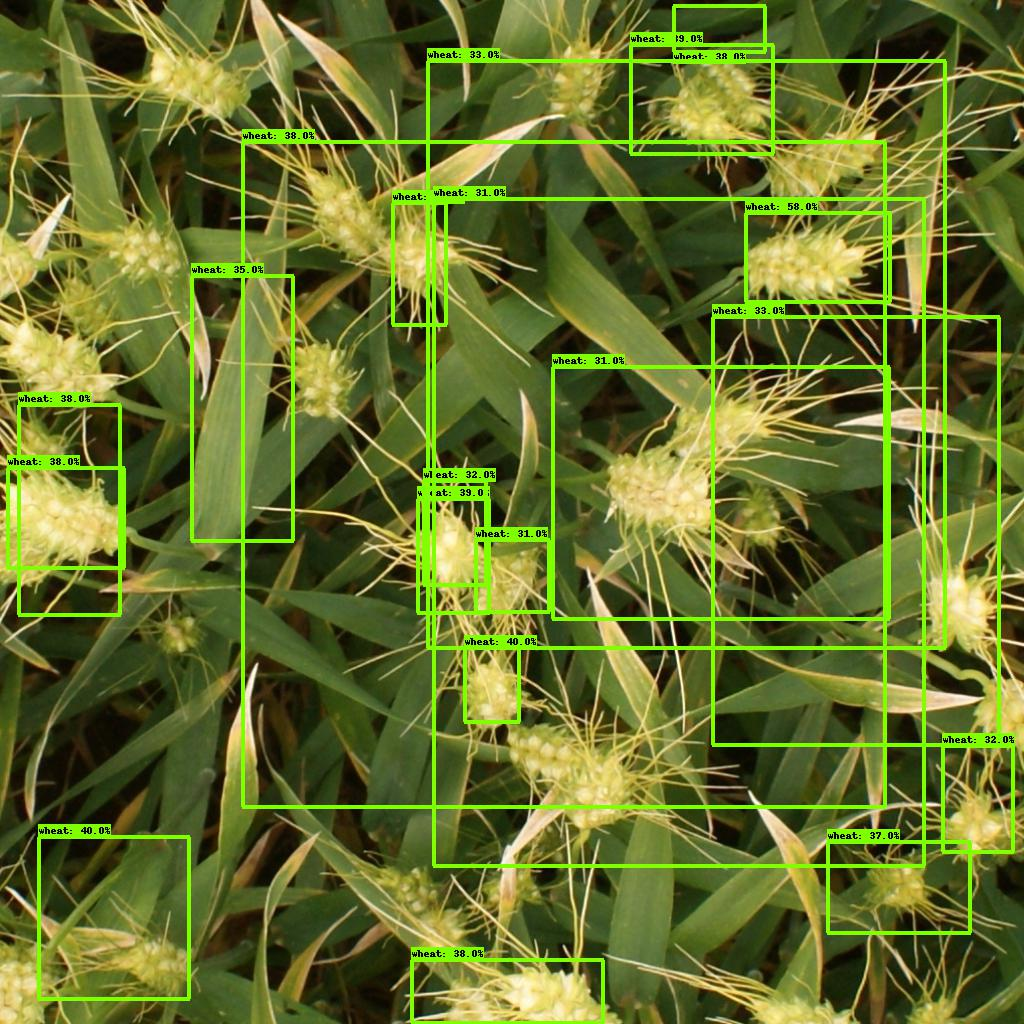

In [42]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = 'inf_348a992bb.jpg', width = 512, height = 512)

Granted.. it aint perfect.. but hey 10 mins or less isnt it..    
Too bad the host want it MIT complliant.. this is apache 2.0  
TODO: Throw in WBF...

This was a pleasant surprise to me.. compared to the many kernels that took multiple hours and ensembles that took days to train.  
If you have liked this notebook please upvote..  